In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools

from tqdm import tqdm

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
# DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr3_1'


BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [5]:
# ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
ENSEMBLE_LIST = ['Coarse-2','Coarse-1','Coarse-Phys','Fine-1']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['xfstpar','RA1','ZRA1','XV','R0','R1']

In [6]:
Rs = []
jk = {}
for ens in ENSEMBLE_LIST:
    jk[ens] = {}
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        jk[ens][mom] = {}
        for rat in RATIO_LIST:
            try:
                res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                    path = DATA_2PT,
                    jk = JKFIT
                )
            except FileNotFoundError:
                continue

            f0 = res['ratio'][0] if JKFIT else res[-1]['ratio'][0]

            if JKFIT:
                jk[ens][mom][rat] = f0
                r = gv.gvar(f0.mean(),f0.std()*np.sqrt(len(f0)-1))
            else:
                r = f0

            if rat=='RA1':
                r = np.sqrt(r)
            elif rat=='ZRA1':
                r = np.sqrt(gv.gvar(-r.mean,r.sdev))
            elif rat=='R0':
                r *= -1 

            
            if rat=='xfstpar':
                try:
                    aux['wrecoil'] = (1+r**2)/(1-r**2)
                except TypeError:
                    aux['wrecoil'] = None

                # if mom=='000':
                #     aux[rat] = gv.gvar('1(0)')
                #     aux['wrecoil'] = gv.gvar('1(0)')

            aux[rat] = r
        Rs.append(aux)

Rs = pd.DataFrame(Rs).set_index(['ensemble','mom'])

Rs = Rs.drop(('Coarse-1','400'))
Rs = Rs.drop(('Coarse-2','400'))

for ens in ENSEMBLE_LIST:
    Rs.loc[(ens,'000'),'wrecoil'] = gv.gvar('1(0)')

In [7]:
print(Rs[['wrecoil','xfstpar','ZRA1','RA1','XV','R0','R1']])

                    wrecoil      xfstpar        ZRA1         RA1          XV          R0         R1
ensemble    mom                                                                                    
Coarse-2    000        1(0)          NaN   0.917(20)         NaN         NaN         NaN        NaN
            100  1.0223(26)  -0.1051(62)         NaN   0.748(14)  0.1455(84)   0.169(20)  1.065(23)
            200   1.088(11)   -0.206(12)         NaN   0.675(24)   0.303(15)   0.351(13)  1.284(67)
            300   1.135(23)   -0.252(20)         NaN   0.659(24)   0.410(24)   0.589(34)  1.570(30)
Coarse-1    000        1(0)          NaN   0.902(13)         NaN         NaN         NaN        NaN
            100   1.020(12)   -0.099(29)         NaN   0.802(28)  0.1172(61)   0.157(15)  1.067(19)
            200   1.063(20)   -0.174(27)         NaN   0.800(22)  0.2256(92)   0.290(18)  1.175(24)
            300   1.113(36)   -0.231(35)         NaN   0.799(23)   0.307(14)   0.412(30)  1.316(46)


In [8]:
FF = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}

        if not (ens,mom) in Rs.index:
            continue

        w   = Rs['wrecoil'].loc[ens,mom]
        RA1 = Rs['RA1' if mom!='000' else 'ZRA1'].loc[ens,mom]
        XV  = Rs['XV'     ].loc[ens,mom]
        X0  = Rs['R0'     ].loc[ens,mom]
        X1  = Rs['R1'     ].loc[ens,mom]



        if w is None:
            continue

        aux['wrecoil'] = w
        aux['hA1']     = 2*RA1/(w+1)

        if mom=='000':
            aux['hA2'] = None
            aux['hA3'] = None
            aux['hV']  = None
        else:
            aux['hA2'] = 2*RA1/(w**2-1) * (w*X1 - np.sqrt(w**2-1)*X0-1)
            aux['hA3'] = 2*RA1/(w**2-1)*(w-X1)
            aux['hV']  = 2*RA1/np.sqrt(w**2-1) * XV

        FF.append(aux)

FF = pd.DataFrame(FF).set_index(['ensemble','mom'])
FF

wrecoil         hA1       hA2        hA3         hV
ensemble    mom                                                        
Coarse-2    000        1(0)   0.917(20)      None       None       None
            100  1.0223(26)   0.740(13)  1.75(82)  -1.41(81)  1.024(87)
            200   1.088(11)   0.647(24)  1.80(57)  -1.43(56)  0.951(82)
            300   1.135(23)   0.617(23)  2.12(40)  -1.98(49)   1.01(12)
Coarse-1    000        1(0)   0.902(13)      None       None       None
            100   1.020(12)   0.794(28)  2.3(1.4)  -1.9(1.7)   0.94(28)
            200   1.063(20)   0.776(23)  1.79(62)  -1.39(78)   1.01(17)
            300   1.113(36)   0.756(25)  1.77(62)  -1.36(76)   1.01(18)
Coarse-Phys 000        1(0)  0.9102(72)      None       None       None
            100  1.0058(11)  0.7729(61)  5.4(1.8)  -4.9(1.8)   1.18(13)
            200  1.0222(26)  0.7535(96)  3.14(70)  -2.65(72)  1.061(74)
            300  1.0453(52)   0.706(53)  3.24(73)  -2.76(73)   1.00(10)
            400  1.0813(78)   0.681(27)  1.67(32)  -1.22(32)  0.920(66)
Fine-1      000        1(0)  0.9111(97)      None       None       None
            100  1.0197(77)   0.771(16)  0.33(63)   0.36(63)   0.78(16)
            200  1.0452(59)   0.761(13)  0.88(53)  -0.42(53)  1.012(74)
            300  1.0950(97)   0.732(20)  1.52(52)  -1.07(43)  0.982(64)
            400   1.146(40)   0.741(15)  1.98(56)  -1.57(69)   1.07(16)

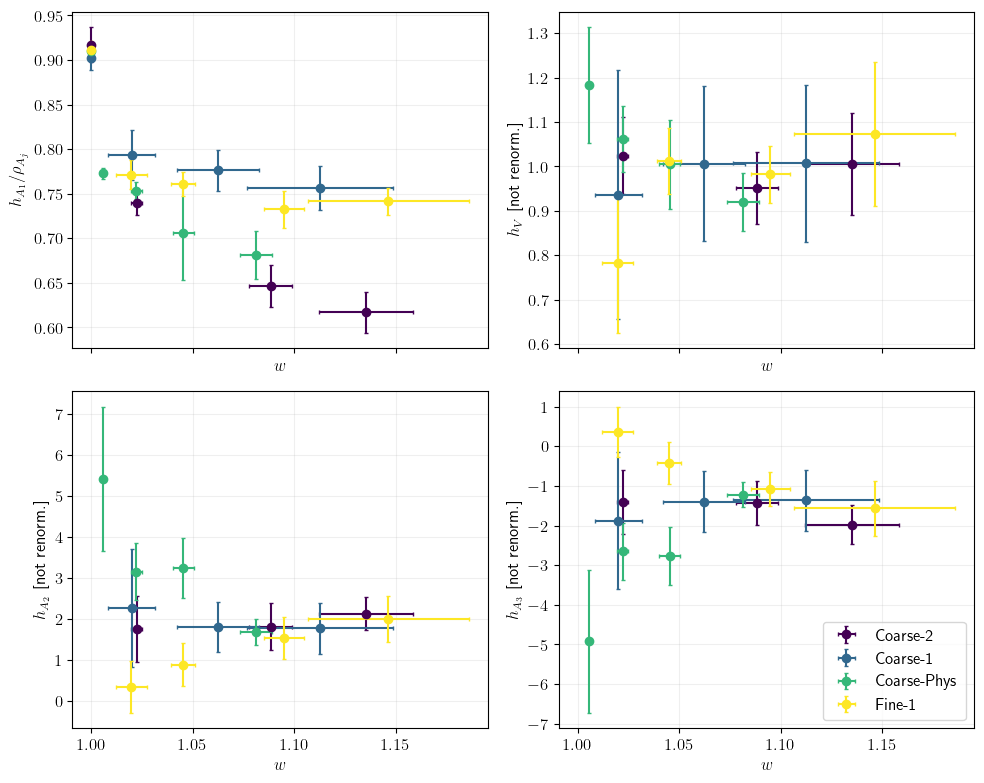

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(2,2,figsize=(10,8),sharex=True)
f, ax = plt.subplots(2,2,figsize=(10,8),sharex=True)


color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0,0].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA1'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA1'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    dfy = FF['hV'].loc[ens].dropna()
    mask = FF.loc[ens].index.isin(dfy.index)
    dfx = FF['wrecoil'].loc[ens][mask]
    ax[0,1].errorbar(
        gv.mean(dfx.values),
        gv.mean(dfy.values),
        xerr = gv.sdev(dfx.values),
        yerr = gv.sdev(dfy.values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )


    dfy = FF['hA2'].loc[ens].dropna()
    mask = FF.loc[ens].index.isin(dfy.index)
    dfx = FF['wrecoil'].loc[ens][mask]
    ax[1,0].errorbar(
        gv.mean(dfx.values),
        gv.mean(dfy.values),
        xerr = gv.sdev(dfx.values),
        yerr = gv.sdev(dfy.values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    dfy = FF['hA3'].loc[ens].dropna()
    mask = FF.loc[ens].index.isin(dfy.index)
    dfx = FF['wrecoil'].loc[ens][mask]
    ax[1,1].errorbar(
        gv.mean(dfx.values),
        gv.mean(dfy.values),
        xerr = gv.sdev(dfx.values),
        yerr = gv.sdev(dfy.values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )


    # ax.errorbar(xin+off,gv.mean(yin),gv.sdev(yin),fmt=mrk[i%2], ecolor=color, mfc='w', color=color, capsize=2.5,alpha=alpha)

ax[0,0].set_ylabel(r'$h_{A_1}/\rho_{A_j}$')
ax[0,0].set_xlabel(r'$w$')
ax[0,0].grid(alpha=0.2)

ax[1,1].legend()
ax[1,1].set_ylabel(r'$h_{A_3}$  [not renorm.]')
ax[1,1].set_xlabel(r'$w$')
ax[1,1].grid(alpha=0.2)

ax[0,1].set_ylabel(r'$h_V$  [not renorm.]')
ax[0,1].set_xlabel(r'$w$')
ax[0,1].grid(alpha=0.2)

ax[1,0].set_ylabel(r'$h_{A_2}$  [not renorm.]')
ax[1,0].set_xlabel(r'$w$')
ax[1,0].grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/ff.pdf')


In [12]:
df = Rs.drop(('Coarse-1','000'))
df = df.drop(('Coarse-2','000'))
df = df.drop(('Coarse-Phys','000'))
df = df.drop(('Fine-1','000'))

In [13]:
df['RA1']/np.sqrt(df['wrecoil']**2 - 1) * df['XV']

ensemble     mom
Coarse-2     100     1.21(10)
             200    1.121(91)
             300     1.15(12)
Coarse-1     100     1.10(33)
             200     1.17(20)
             300     1.16(20)
Coarse-Phys  100     1.38(15)
             200    1.244(87)
             300    1.228(90)
             400    1.052(69)
Fine-1       100     0.91(18)
             200    1.154(85)
             300    1.100(71)
             400     1.19(18)
dtype: object

# $h_{A_2}$

In [10]:
2 * df['RA1']/(df['wrecoil']**2 - 1)  * (
    df['wrecoil']*df['R1'] - np.sqrt(df['wrecoil']**2 -1) * df['R0'] - 1
)

NameError: name 'df' is not defined

In [64]:
2 * df['RA1']/(df['wrecoil']**2 - 1) 

ensemble     mom
Coarse-2     100    39.0(4.8)
             200     8.7(1.1)
             300     5.40(99)
Coarse-1     100       47(28)
             200    14.5(4.8)
             300     7.7(2.6)
Coarse-Phys  100      156(28)
             200    39.8(4.8)
             300    19.0(2.3)
             400     9.6(1.0)
Fine-1       100       45(18)
             200    19.2(2.6)
             300     8.64(95)
             400     5.6(1.6)
dtype: object

In [67]:
df['wrecoil']

ensemble     mom
Coarse-2     100    1.0223(26)
             200     1.088(11)
             300     1.135(23)
Coarse-1     100     1.020(12)
             200     1.063(20)
             300     1.113(36)
Coarse-Phys  100    1.0058(11)
             200    1.0222(26)
             300    1.0453(52)
             400    1.0813(78)
Fine-1       100    1.0197(77)
             200    1.0452(59)
             300    1.0950(97)
             400     1.146(40)
Name: wrecoil, dtype: object

In [66]:
df['R1']

ensemble     mom
Coarse-2     100    1.065(23)
             200    1.284(67)
             300    1.570(30)
Coarse-1     100    1.067(19)
             200    1.175(24)
             300    1.316(46)
Coarse-Phys  100    1.043(11)
             200    1.100(17)
             300    1.223(36)
             400    1.228(30)
Fine-1       100    1.010(16)
             200    1.070(30)
             300    1.234(50)
             400    1.456(45)
Name: R1, dtype: object

In [63]:
2 * df['RA1']/(df['wrecoil']**2 - 1)  * (df['wrecoil']-df['R1'])

ensemble     mom
Coarse-2     100    -1.66(95)
             200    -1.70(66)
             300    -2.35(58)
Coarse-1     100    -2.2(2.0)
             200    -1.63(91)
             300    -1.57(88)
Coarse-Phys  100    -5.7(2.1)
             200    -3.11(84)
             300    -3.38(86)
             400    -1.40(36)
Fine-1       100     0.42(73)
             200    -0.48(60)
             300    -1.20(48)
             400    -1.74(77)
dtype: object